importing libraries


In [3]:
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

data prep

In [4]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [ ]:
traindf=mnist_dataset['train']
testdf=mnist_dataset['test']

In [6]:
trainX=[]
trainY=[]
testX=[]
testY=[]
for image, label in traindf:
    trainX.append(image.numpy().squeeze()) 
    trainY.append(label.numpy())

for image, label in testdf:
    testX.append(image.numpy().squeeze()) 
    testY.append(label.numpy())

trainX=np.array(trainX)
trainY=np.array(trainY)
testX=np.array(testX)
testY=np.array(testY)


print("Training images shape:",trainX.shape)
print("Training labels shape:", trainY.shape)
print("Test images shape:", testX.shape)
print("Test labels shape:", testY.shape)


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


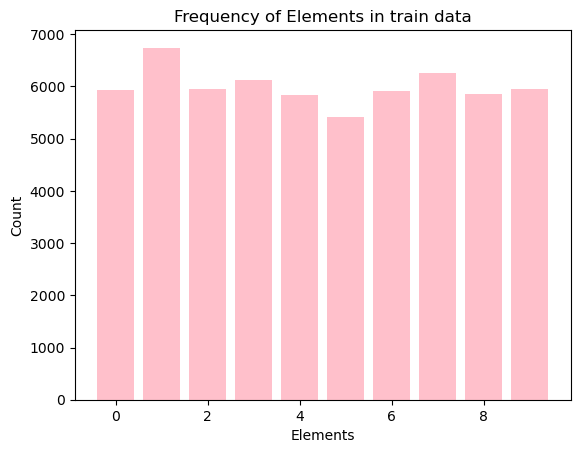

In [5]:
unt,untc=np.unique(trainY,return_counts=True)
plt.bar(unt, untc, color='pink')
plt.xlabel('Elements')
plt.ylabel('Count')
plt.title('Frequency of Elements in train data')
plt.show()


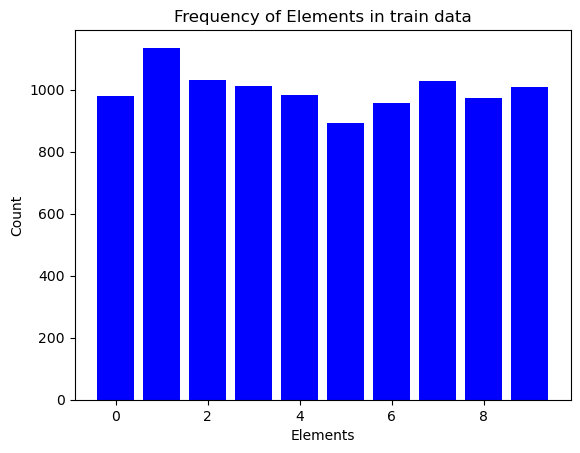

In [6]:
unt,untc=np.unique(testY,return_counts=True)
plt.bar(unt, untc, color='blue')
plt.xlabel('Elements')
plt.ylabel('Count')
plt.title('Frequency of Elements in train data')
plt.show()

In [7]:
trainX = trainX.astype('float32') / 255.0  # Scale to [0, 1]
testX = testX.astype('float32') / 255.0
trainX = np.expand_dims(trainX, axis=-1)  # Adds channel dimension (e.g., for grayscale)
testX = np.expand_dims(testX, axis=-1)

trainX=trainX.reshape(trainX.shape[0],-1)
testX=testX.reshape(testX.shape[0],-1)

trainY=np.eye(10)[trainY]
testY=np.eye(10)[testY]

print("X_train shape:", trainX.shape)  
print("y_train shape:", trainY.shape)  

X_train shape: (60000, 784)
y_train shape: (60000, 10)


In [8]:
valXn=int(trainX.shape[0]*0.15)
valX=trainX[trainX.shape[0]-valXn:]
valY=trainY[trainY.shape[0]-valXn:]
trainX=trainX[0:trainX.shape[0]-valXn]
trainY=trainY[0:trainY.shape[0]-valXn]

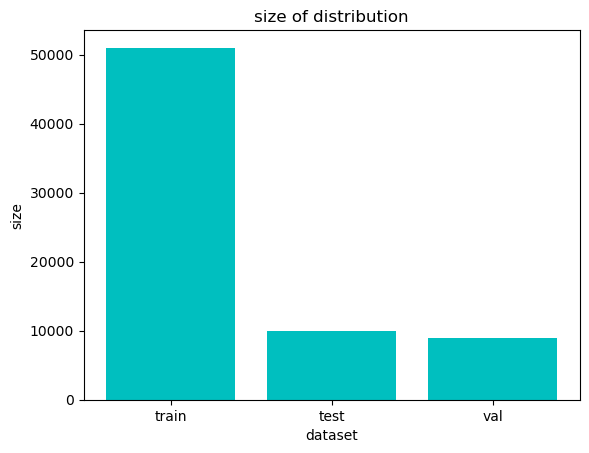

In [9]:
names=["train","test","val"]
size=[trainX.shape[0],testX.shape[0],valX.shape[0]]
plt.bar(names, size, color='c')
plt.xlabel('dataset')
plt.ylabel('size')
plt.title('size of distribution')
plt.show()

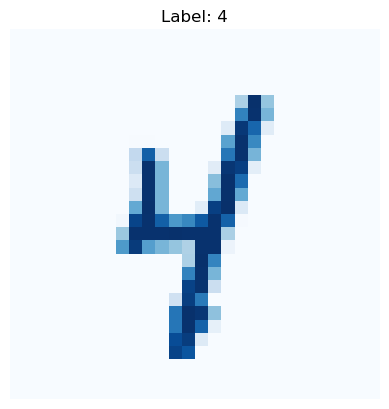

In [12]:
import matplotlib.pyplot as plt

# Extract one batch (or example) from the dataset
for image, label in traindf.take(1):
    # Convert TensorFlow tensors to numpy arrays
    image_np = image.numpy().squeeze()  # Shape: (28, 28, 1) → (28, 28)
    label_np = label.numpy()

    # Plot the image
    plt.imshow(image_np, cmap='Blues')
    plt.title(f"Label: {label_np}")
    plt.axis('off')
    plt.show()

In [9]:
import numpy as np
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x,axis=1,keepdims=True))
    return e_x / e_x.sum(axis=1,keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    return -np.mean(y_true * np.log(y_pred + 1e-8))

def print_predictions(preds, n=5):
    for i, probs in enumerate(preds[:n]):
        print(f"Sample {i}:")
        for cls, prob in enumerate(probs):
            print(f"  Class {cls}: {prob*100:.2f}%")
            

In [10]:
# when creating a layer think about how the array or layer interacts instead of each individual node
class Layer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim)*np.sqrt(2./input_dim) #HE intialization
        self.bias = np.zeros((1, output_dim))#np.zeros creates an array of given length filled with zero
    
    def forward(self,input):
        self.input=input
        self.z=(np.dot(input,self.weights)+self.bias)
        self.z=relu(self.z)
        return self.z
    
    def backward(self, grad, learning_rate):
        delta = grad * relu_derivative(self.z)
        dW = np.dot(self.input.T, delta)
        db = np.sum(delta, axis=0, keepdims=True)
        dW = np.clip(dW, -1, 1)
        db = np.clip(db, -1, 1)
        self.weights -= learning_rate * dW
        self.bias -= learning_rate * db
        grad_prev = np.dot(delta, self.weights.T)
        return grad_prev
    

class Outputlayer(Layer):
    def forward(self, input):
        self.input=input
        self.z=(np.dot(input,self.weights)+self.bias)
        self.z=softmax(self.z)
        return self.z
    
    def backward(self, grad, learning_rate):
        dW = np.dot(self.input.T, grad)
        db = np.sum(grad, axis=0, keepdims=True)
        # dW = np.clip(dW, -1, 1)
        # db = np.clip(db, -1, 1)
        self.weights -= learning_rate * dW
        self.bias -= learning_rate * db
        return np.dot(grad, self.weights.T)



In [11]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size=1):
        self.layers = []
        sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)):
            self.layers.append(Layer(sizes[i], sizes[i+1]))
        self.layers.append(Outputlayer(hidden_sizes[-1], output_size))
    
    def forward(self, X):
        a = X
        for layer in self.layers:
            a = layer.forward(a)
        return a
    
    def backward(self, X, y, learning_rate):
        y_pred = self.forward(X)
        m = X.shape[0]
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        grad = (y_pred - y) / m
        for layer in reversed(self.layers):
            grad = layer.backward(grad, learning_rate)

In [21]:
def pojectresult(loss,acc,epoch,name):
    epoch=np.arange(epoch)
    plt.figure(figsize=(8, 5))
    plt.plot(epoch, loss, label=f"{name} loss", color="blue")
    plt.plot(epoch, acc, label=f"{name} accuracy", color="red")
    plt.xlabel("epoch")
    plt.title(f"{name} Graph")
    plt.grid(True)
    plt.legend()
    plt.show()

In [22]:
def train_model( input_size, hidden_units, epochs=100, lr=0.09):
    losst=[]
    lossval=[]
    acct=[]
    accval=[]
    X_train, y_train=trainX,trainY
    X_val, y_val = valX,valY
    model = NeuralNetwork(input_size=input_size, hidden_sizes=hidden_units, output_size=10)
    for epoch in range(epochs):
        y_pred = model.forward(X_train)
        loss = cross_entropy_loss(y_pred,y_train,)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1))
        losst.append(loss)
        acct.append(accuracy)
        model.backward(X_train, y_train, lr)
        val_pred = model.forward(X_val)
        val_loss = cross_entropy_loss(val_pred,y_val)
        val_accuracy = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_val, axis=1))
        lossval.append(val_loss)
        accval.append(val_accuracy)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Train Loss: {loss:.4f} | Accuracy: {accuracy:.4f} | Val Loss: {val_loss:.4f}| Accuracy: {val_accuracy:.4f}")
    pojectresult(loss=losst,acc=acct,epoch=epochs,name="train")
    pojectresult(loss=lossval,acc=accval,epoch=epochs,name="validation")
    return model
    

In [14]:
def evaluate_model(model):
    X_test, y_test = testX,testY
    y_pred = model.forward(X_test)
    loss = cross_entropy_loss(y_pred,y_test)
    accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(testY, axis=1))
    print(f"Test Loss: {loss:.4f} | Accuracy: {accuracy:.4f}")

In [15]:
INPUT_SIZE=784
HIDDEN_UNITS=[128,64]

Epoch 0 | Train Loss: 0.2341 | Accuracy: 0.1035 | Val Loss: 0.2230| Accuracy: 0.1651
Epoch 10 | Train Loss: 0.1568 | Accuracy: 0.6239 | Val Loss: 0.1497| Accuracy: 0.6432
Epoch 20 | Train Loss: 0.1049 | Accuracy: 0.7469 | Val Loss: 0.1006| Accuracy: 0.7638
Epoch 30 | Train Loss: 0.0781 | Accuracy: 0.8118 | Val Loss: 0.0756| Accuracy: 0.8221
Epoch 40 | Train Loss: 0.0641 | Accuracy: 0.8401 | Val Loss: 0.0623| Accuracy: 0.8476
Epoch 50 | Train Loss: 0.0557 | Accuracy: 0.8567 | Val Loss: 0.0545| Accuracy: 0.8624
Epoch 60 | Train Loss: 0.0503 | Accuracy: 0.8667 | Val Loss: 0.0494| Accuracy: 0.8722
Epoch 70 | Train Loss: 0.0464 | Accuracy: 0.8745 | Val Loss: 0.0458| Accuracy: 0.8796
Epoch 80 | Train Loss: 0.0436 | Accuracy: 0.8804 | Val Loss: 0.0432| Accuracy: 0.8840
Epoch 90 | Train Loss: 0.0414 | Accuracy: 0.8858 | Val Loss: 0.0411| Accuracy: 0.8892


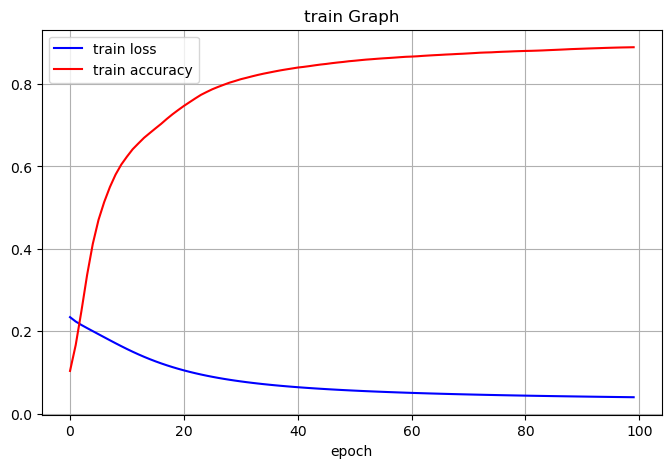

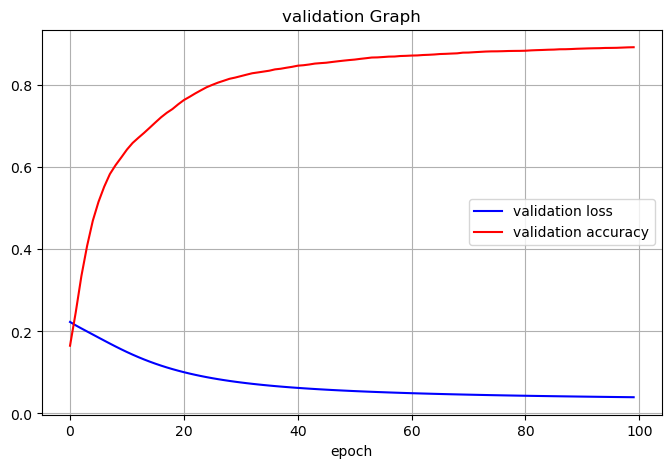

In [23]:
model = train_model(
input_size=INPUT_SIZE,
hidden_units=HIDDEN_UNITS)
# evaluate_model(model)

In [24]:
evaluate_model(model)

Test Loss: 0.0382 | Accuracy: 0.8960


In [88]:
# 1. Verify your data shapes
print(f"Train shapes - X: {trainX.shape}, y: {trainY.shape}")
print(f"Test shapes - X: {testX.shape}, y: {testY.shape}")

# 2. Check prediction distribution
y_pred = model.forward(testX[:5])  # First 5 samples
print_predictions(y_pred)

# 3. Verify gradient magnitudes
for layer in model.layers:
    print(f"Layer weights mean: {np.mean(layer.weights):.4f}, std: {np.std(layer.weights):.4f}")

Train shapes - X: (43350, 784), y: (43350, 10)
Test shapes - X: (10000, 784), y: (10000, 10)
Sample 0:
  Class 0: 8.27%
  Class 1: 0.41%
  Class 2: 79.16%
  Class 3: 1.04%
  Class 4: 1.98%
  Class 5: 4.01%
  Class 6: 2.47%
  Class 7: 0.12%
  Class 8: 1.13%
  Class 9: 1.41%
Sample 1:
  Class 0: 97.42%
  Class 1: 0.00%
  Class 2: 0.14%
  Class 3: 0.15%
  Class 4: 0.00%
  Class 5: 1.82%
  Class 6: 0.11%
  Class 7: 0.00%
  Class 8: 0.34%
  Class 9: 0.01%
Sample 2:
  Class 0: 0.01%
  Class 1: 0.01%
  Class 2: 0.04%
  Class 3: 0.04%
  Class 4: 96.54%
  Class 5: 0.01%
  Class 6: 0.09%
  Class 7: 0.80%
  Class 8: 0.16%
  Class 9: 2.29%
Sample 3:
  Class 0: 3.07%
  Class 1: 12.13%
  Class 2: 7.97%
  Class 3: 4.58%
  Class 4: 4.07%
  Class 5: 17.97%
  Class 6: 4.52%
  Class 7: 4.05%
  Class 8: 38.64%
  Class 9: 3.02%
Sample 4:
  Class 0: 0.02%
  Class 1: 0.04%
  Class 2: 0.17%
  Class 3: 0.05%
  Class 4: 0.35%
  Class 5: 0.14%
  Class 6: 0.01%
  Class 7: 98.10%
  Class 8: 0.12%
  Class 9: 1.00%


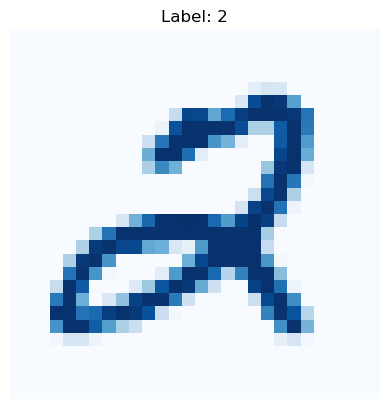

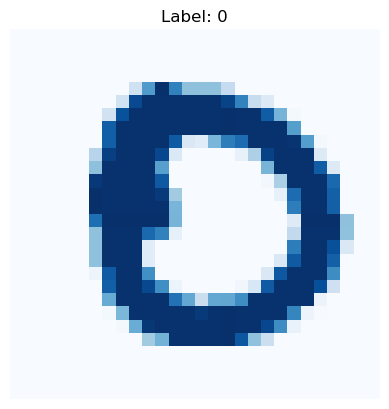

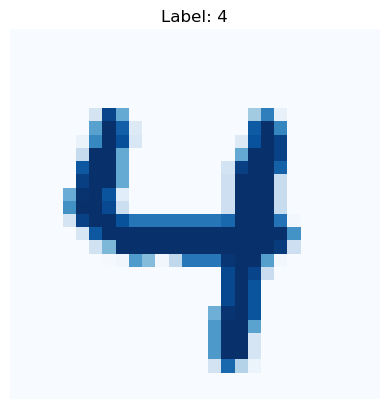

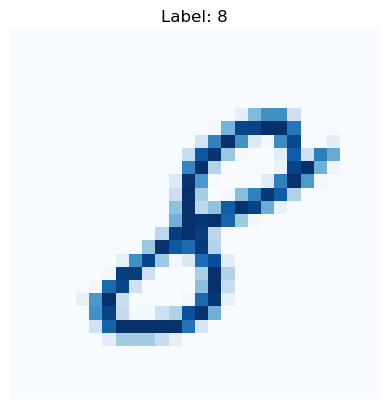

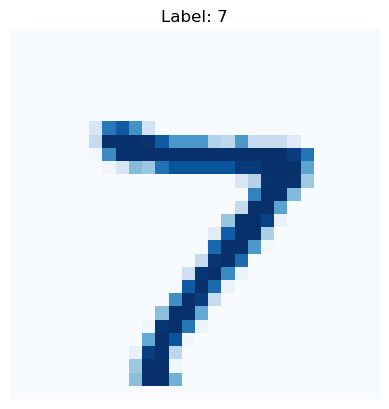

In [57]:
for i in range(5):
    plt.imshow(testX[i], cmap='Blues')
    plt.title(f"Label: {testY[i]}")
    plt.axis('off')
    plt.show()